### 方法
```
while 調べるべき特徴量がある限り :
    for 調べる特徴量 in 調べる特徴量の数 :
        ある特徴量ベクトルxiと元のy(y^)の内積を求める(t^i)
        for 100程度 :
            y^を、{t0 = t^0かつt1 = t^1...tj = t^j}という条件の元サンプリング（nealを使う）しyを生成する。
            ある特徴量ベクトルxiとyの内積を求める(ti)
        複数のtiを求めることによって得られた分布に対するt^iの位置から、p値を求める。
    p値の一番小さいXsを知る。
    条件{}にts = t^sを足す（更新する）
    調べる特徴量からXsを除外（更新する）
```

#### 条件について
- t0 = t^0 : 1の総和が同じ
- tj = t^j : xの特徴量jつ目とyの内積の値が同じ


### yのサンプリング
- 条件に合うまでサンプルを作り続ける

### 改訂(08/03)
- ori_tiのkeyがなかった場合に1とする必要がない
- sum([j[1] for j in ti_list])は必ず100である
- 正確な分布を作ることが必要なので、yを全列挙する必要がある。

In [98]:
#!pip3 install dwave-neal

In [99]:
import pandas as pd 
import numpy as np
from neal import SimulatedAnnealingSampler
from pyqubo import Array, Constraint, Placeholder, solve_qubo
import itertools

In [100]:
%matplotlib inline
import matplotlib.pyplot as plt

In [101]:
X_mushroom = pd.read_csv("../input/SNP_df1010.csv", sep=',', index_col=0)
y_mushroom = pd.read_csv('../input/y10.csv', sep=',', index_col=0)['y']

num_samples = X_mushroom.shape[0]
num_cols = X_mushroom.shape[1]
columns = list(X_mushroom.columns)

y_sum = sum(y_mushroom)

In [107]:
columns

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']

In [102]:
num_samples

10

In [103]:
y_sum

6

##### トライアル（t^0だけ）

In [104]:
y_list = []
y_list_all = itertools.product('01', repeat=num_samples)

for y_tuple in y_list_all:
    y_list_list = [int(n) for n in list(y_tuple)]
    y = pd.Series(y_list_list)

    if sum(y) - y_sum == 0:
        y_list.append(y)
#y_list

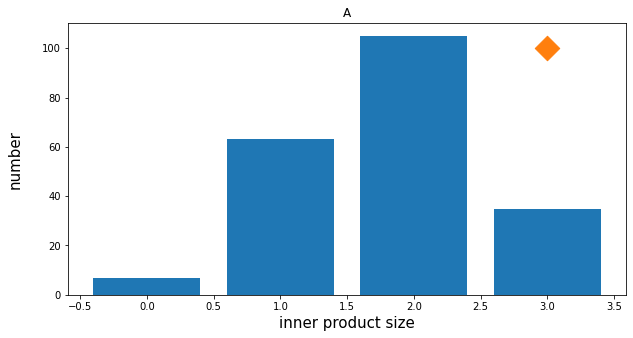

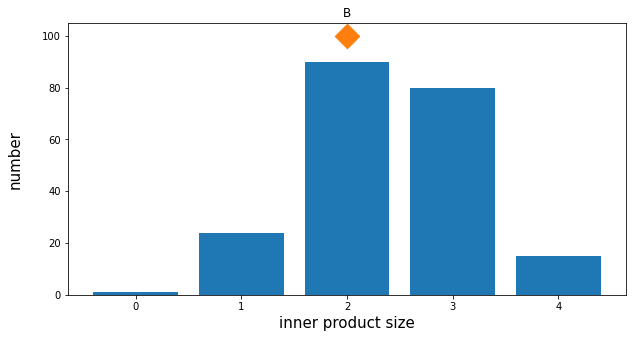

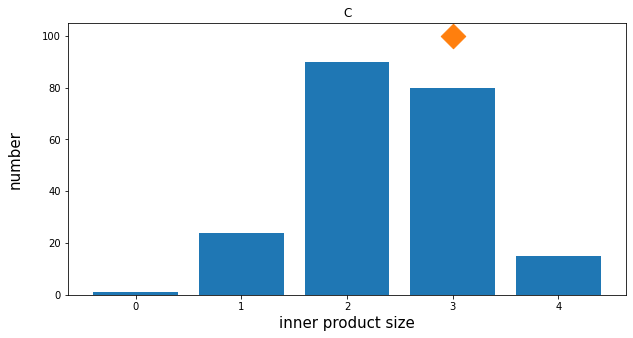

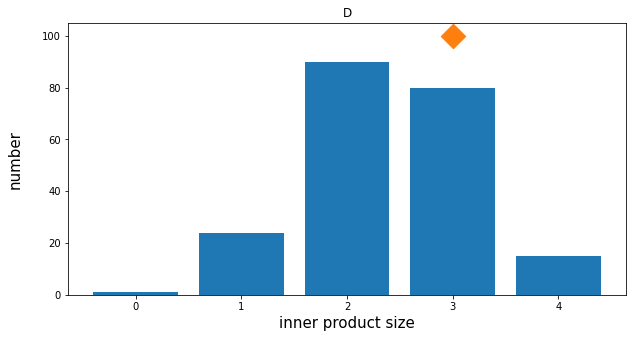

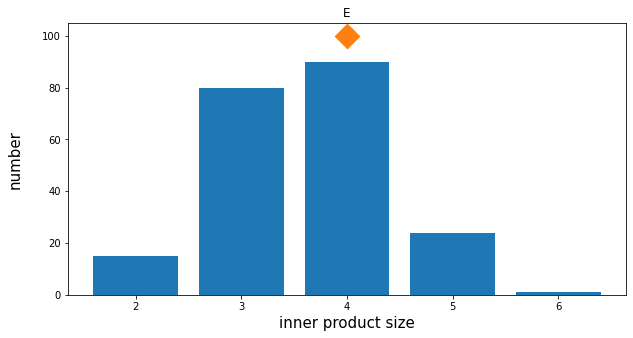

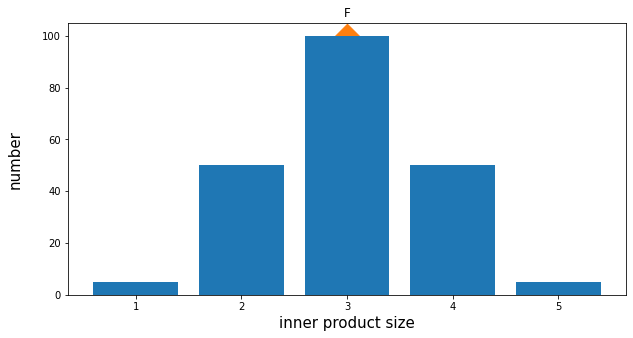

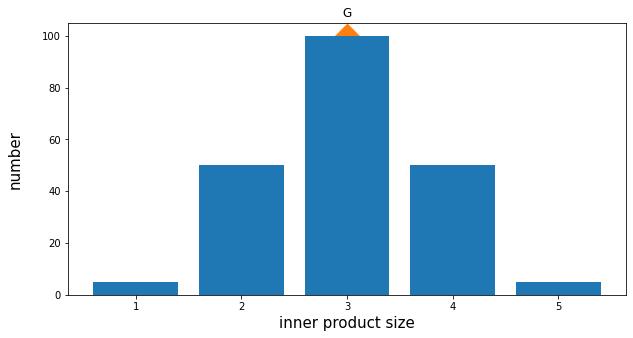

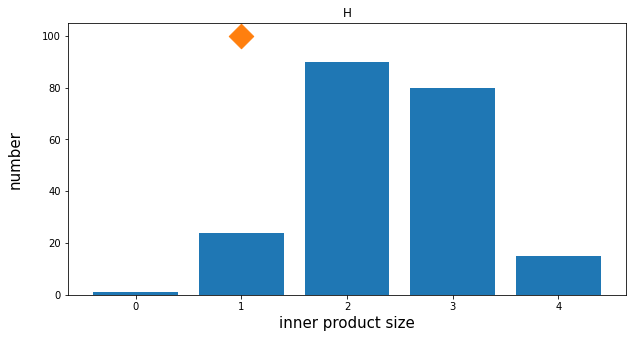

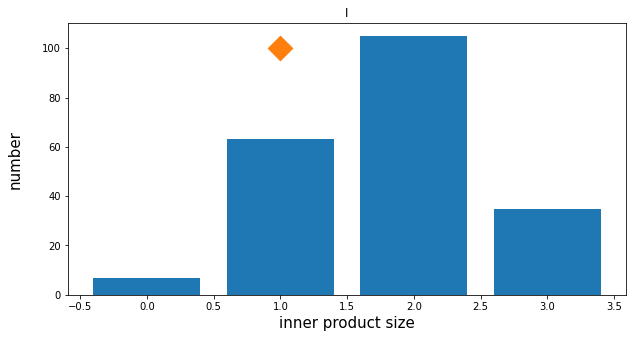

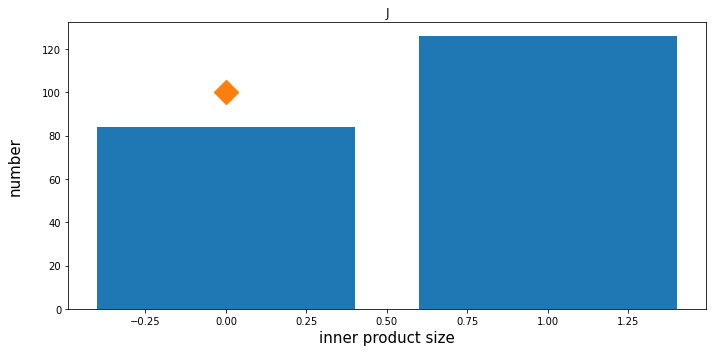

In [124]:
minP_cols = []
servey_num_col_list = columns

p = {}
for i in servey_num_col_list:
    
    ori_ti = int(np.dot(X_mushroom[i], y_mushroom)) #特徴量iを表すp

    ti_dic = {} #{内積の値:該当数}という辞書。
    y_list = make_y(minP_cols)

    for y in y_list:       
        if int(np.dot(X_mushroom[i], y)) in ti_dic.keys():
            ti_dic[int(np.dot(X_mushroom[i], y))] += 1
        else:
            ti_dic[int(np.dot(X_mushroom[i], y))] = 1

    ti_list = sorted(ti_dic.items()) #listになり、要素はタプルになる。
    franc = sum([j[1] for j in ti_list if j[0] >= ori_ti])
    p[i] = franc/len(y_list)
    
    # ヒストグラムを出力
    plt.figure(figsize=(10, 5))
    plt.title(i) 
    plt.bar([j[0] for j in ti_list], [j[1] for j in ti_list])
    plt.xlabel('inner product size', fontsize=15)
    plt.ylabel('number', rotation=90, fontsize=15, labelpad=20)
    plt.scatter(ori_ti, 100, s=300, marker='D')

#図が重ならないようにする
plt.tight_layout()

#図を表示
plt.show()

In [90]:
def make_y(minP_cols):
    y_list = []
    y_list_all = itertools.product('01', repeat=num_samples)

    for y_tuple in y_list_all:
        y_list_list = [int(n) for n in list(y_tuple)]
        y = pd.Series(y_list_list)

        if sum(y) - y_sum != 0:
            continue

        if len(minP_cols) == 0:
            y_list.append(y)
        else:
            for i in minP_cols:
                if np.dot(X_mushroom[i], y) - np.dot(X_mushroom[i], y_mushroom) != 0:
                    continue        
            y_list.append(y)
    return y_list

In [91]:
minP_cols = []
servey_num_col_list = columns

while len(servey_num_col_list) > 0:    
    p = {}
    for i in servey_num_col_list:
        ori_ti = int(np.dot(X_mushroom[i], y_mushroom)) #特徴量iを表すp
        
        ti_dic = {} #{内積の値:該当数}という辞書。
        y_list = make_y(minP_cols)
        
        for y in y_list:       
            if int(np.dot(X_mushroom[i], y)) in ti_dic.keys():
                ti_dic[int(np.dot(X_mushroom[i], y))] += 1
            else:
                ti_dic[int(np.dot(X_mushroom[i], y))] = 1
                
        count_better_t = sum([v for k, v in ti_dic.items() if k >= ori_ti])
        p[i] = count_better_t / len(y_list)
        
    minP_keys = [k for k, v in p.items() if v == min(list(p.values()))]
    print(minP_keys)
    minP_cols += minP_keys
    servey_num_col_list = [i for i in servey_num_col_list if i not in minP_keys]

['A']
['C', 'D']
['E']
['F', 'G']
['B']
['I']
['H']
['J']


In [92]:
minP_cols #['A', 'C', 'D', 'E', 'F', 'G', 'B', 'I', 'H', 'J']

['A', 'C', 'D', 'E', 'F', 'G', 'B', 'I', 'H', 'J']

In [9]:
'''
def make_y1(minP_cols):
    while True:
        y = [[0, 1][random.randint(0, 1)]for jj in range(num_samples)]
        if sum(y) - y_sum != 0:
            continue
        if len(minP_cols) == 0:
            return pd.Series(y)
        else:
            for i in minP_cols:
                if np.dot(X_mushroom[i], y) - np.dot(X_mushroom[i], y_mushroom) != 0:
                    continue
            return pd.Series(y)
結果            
#minP_cols #['B', 'F', 'G', 'A', 'C', 'D', 'E', 'H', 'I', 'J']
'''

In [ ]:
'''
minP_cols = []
servey_num_col_list = columns

while len(servey_num_col_list) > 0:    
    p = {}
    for i in servey_num_col_list:
        ori_ti = int(np.dot(X_mushroom[i], y_mushroom)) #特徴量iを表すp
        
        ti_dic = {} #分布の要素となる値を格納する
        for _ in range(100): 
            y = make_y(minP_cols)
            
            if int(np.dot(X_mushroom[i], y)) in ti_dic.keys():
                ti_dic[int(np.dot(X_mushroom[i], y))] += 1
            else:
                ti_dic[int(np.dot(X_mushroom[i], y))] = 1
                
        bunshi = sum([ti_dic[ii] for ii in range(ori_ti, int(list(ti_dic.keys())[-1])+1)])
        p[i] = bunshi/sum(list(ti_dic.values()))
        
    minP_keys = [k for k, v in p.items() if v == min(list(p.values()))]
    minP_cols += minP_keys
    servey_num_col_list = [i for i in servey_num_col_list if i not in minP_keys]
#minP_cols #['A', 'C', 'D', 'G', 'I', 'H', 'B', 'E', 'F', 'J']
'''

In [ ]:
'''
if not ori_ti in ti_dic.keys():
    ti_dic[ori_ti] = 1                        
ti_list = sorted(ti_dic.items()) #listになり、要素はタプルになる。
franc = sum([j[1] for j in ti_list if j[0] >= ori_ti])
denomi = sum([j[1] for j in ti_list])
p[i] = franc/denomi

↓

count_better_t = sum([v for k, v in ti_dic.items() if k >= ori_ti])
p[i] = count_better_t / distri_element_num


結果
#minP_cols #['A', 'C', 'D', 'E', 'G', 'F', 'B', 'I', 'H', 'J']
'''